<a href="https://colab.research.google.com/github/qjy9ey/trees_assignment/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Trees

## Do two questions in total: "Q1+Q2" or "Q1+Q3"

`! git clone https://github.com/ds3001f25/linear_models_assignment.git`

**Q1.** Please answer the following questions in your own words.
1. Why is the Gini a good loss function for categorical target variables?
2. Why do trees tend to overfit, and how can this tendency be constrained?
3. True or false, and explain: Trees only really perform well in situations with lots of categorical variables as features/covariates.
4. Why don't most versions of classification/regression tree concept allow for more than two branches after a split?
5. What are some heuristic ways you can examine a tree and decide whether it is probably over- or under-fitting?



1.   The Gini index works well for categorical targets because it measures how mixed the classes are within that node. The Gini score goes down when one class dominates a node, which tells the tree that it's doing a good job separating categories.
2.   Decision trees overfit because they can split until every observation is perfectly classified even if those splits are picking up random noise. To prevent that, we can limit how deep the tree grows, require a minimum number of samples to split a node, or use ensemble methods like Random Forests that average out multiple trees.
3.   False. Trees can handle both categorical and numerical variables. They are powerful with numerical variables because they can automatically find non-linear patterns.
4.   Most trees use two branches because they are easier to interpret and compute faster.
5.   If a tree is really deep, has lots of tiny branches, and performs much better on training data than on test data, it is probably overfitting. On the other hand, if the tree is very shallow and its accuracy is low for both training and test data, it's likely underfitting

**Q2.** This is a case study about classification and regression trees.

1. Load the `Breast Cancer METABRIC.csv` dataset. How many observations and variables does it contain? Print out the first few rows of data.

2.  We'll use a consistent set of feature/explanatory variables. For numeric variables, we'll include `Tumor Size`, `Lymph nodes examined positive`, `Age at Diagnosis`. For categorical variables, we'll include `Tumor Stage`, `Chemotherapy`, and `Cancer Type Detailed`. One-hot-encode the categorical variables and concatenate them with the numeric variables into a feature/covariate matrix, $X$.

3. Let's predict `Overall Survival Status` given the features/covariates $X$. There are 528 missing values, unfortunately: Either drop those rows from your data or add them as a category to predict. Constrain the minimum samples per leaf to 10. Print a dendrogram of the tree. Print a confusion matrix of the algorithm's performance. What is the accuracy?

4. For your model in part three, compute three statistics:
    - The **true positive rate** or **sensitivity**:
        $$
        TPR = \dfrac{TP}{TP+FN}
        $$
    - The **true negative rate** or **specificity**:
        $$
        TNR = \dfrac{TN}{TN+FP}
        $$
    Does your model tend to perform better with respect to one of these metrics?

5. Let's predict `Overall Survival (Months)` given the features/covariates $X$. Use the train/test split to pick the optimal `min_samples_leaf` value that gives the highest $R^2$ on the test set (it's about 110). What is the $R^2$? Plot the test values against the predicted values. How do you feel about this model for clinical purposes?

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, classification_report

PATH = "Breast Cancer METABRIC.csv"
df = pd.read_csv(PATH)

print("Original shape:", df.shape)
print("\nColumns (sample):", df.columns.tolist()[:40])
print("\nFirst five rows:")
print(df.head())

Original shape: (2509, 34)

Columns (sample): ['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status', 'PR Status', 'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status', 'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage', "Patient's Vital Status"]

First five rows:
  Patient ID  Age at Diagnosis Type of Breast Surgery    Cancer Type  \
0    MB-0000             75.65             Mastectomy  Breast Cancer   
1    MB-0002             43.19      Br

In [5]:
numeric_cols = ['Tumor Size', 'Lymph nodes examined positive', 'Age at Diagnosis']
categorical_cols = ['Tumor Stage', 'Chemotherapy', 'Cancer Type Detailed']
target_class = 'Overall Survival Status'
target_reg = 'Overall Survival (Months)'

# check existence
missing_cols = [c for c in numeric_cols + categorical_cols + [target_class, target_reg] if c not in df.columns]
if missing_cols:
    raise RuntimeError("Missing columns in CSV: " + ", ".join(missing_cols))

In [6]:
# inspect missingness and drop rows with missing data in selected cols
cols_needed = numeric_cols + categorical_cols + [target_class, target_reg]
print("\nMissing count (selected cols):")
print(df[cols_needed].isna().sum())

df_sub = df[cols_needed].copy()
before = df_sub.shape[0]
df_sub = df_sub.dropna()
after = df_sub.shape[0]
print(f"\nDropped {before-after} rows with missing values; remaining rows: {after}")


Missing count (selected cols):
Tumor Size                       149
Lymph nodes examined positive    266
Age at Diagnosis                  11
Tumor Stage                      721
Chemotherapy                     529
Cancer Type Detailed               0
Overall Survival Status          528
Overall Survival (Months)        528
dtype: int64

Dropped 1109 rows with missing values; remaining rows: 1400


In [7]:
# one-hot encode categoricals and create X, y_class, y_reg
X_num = df_sub[numeric_cols].astype(float).reset_index(drop=True)
X_cat = pd.get_dummies(df_sub[categorical_cols].astype(str), prefix=categorical_cols, dtype=int).reset_index(drop=True)
X = pd.concat([X_num.reset_index(drop=True), X_cat], axis=1)
print("\nFeature matrix X shape after one-hot:", X.shape)
print("\nFirst few columns of X:")
print(X.head())

# map 'Deceased' as positive class = 1, 'Living' = 0 for easier interpretation of TPR/TNR
y_class_raw = df_sub[target_class].astype(str).reset_index(drop=True)
y_class = y_class_raw.map(lambda s: 1 if s.strip().lower() == 'deceased' else 0).astype(int)
if set(y_class.unique()) - {0,1}:
    print("Warning: unexpected values in survival status mapping:", set(y_class_raw.unique()))
y_reg = df_sub[target_reg].astype(float).reset_index(drop=True)

# basic target distribution
print("\nClassification target distribution (Deceased=1, Living=0):")
print(y_class.value_counts())


Feature matrix X shape after one-hot: (1400, 17)

First few columns of X:
   Tumor Size  Lymph nodes examined positive  Age at Diagnosis  \
0        22.0                           10.0             75.65   
1        10.0                            0.0             43.19   
2        15.0                            1.0             48.87   
3        25.0                            3.0             47.68   
4        40.0                            8.0             76.97   

   Tumor Stage_0.0  Tumor Stage_1.0  Tumor Stage_2.0  Tumor Stage_3.0  \
0                0                0                1                0   
1                0                1                0                0   
2                0                0                1                0   
3                0                0                1                0   
4                0                0                1                0   

   Tumor Stage_4.0  Chemotherapy_No  Chemotherapy_Yes  \
0                0              


Confusion matrix (rows=true [Living=0, Deceased=1], cols=predicted [Living=0, Deceased=1]):
[[110  73]
 [ 79 158]]

Overall accuracy: 0.638095238095238

TPR (sensitivity, Deceased positive) = 0.6667
TNR (specificity, Deceased positive) = 0.6011

Classification report (precision / recall / f1):
              precision    recall  f1-score   support

   Living(0)       0.58      0.60      0.59       183
 Deceased(1)       0.68      0.67      0.68       237

    accuracy                           0.64       420
   macro avg       0.63      0.63      0.63       420
weighted avg       0.64      0.64      0.64       420



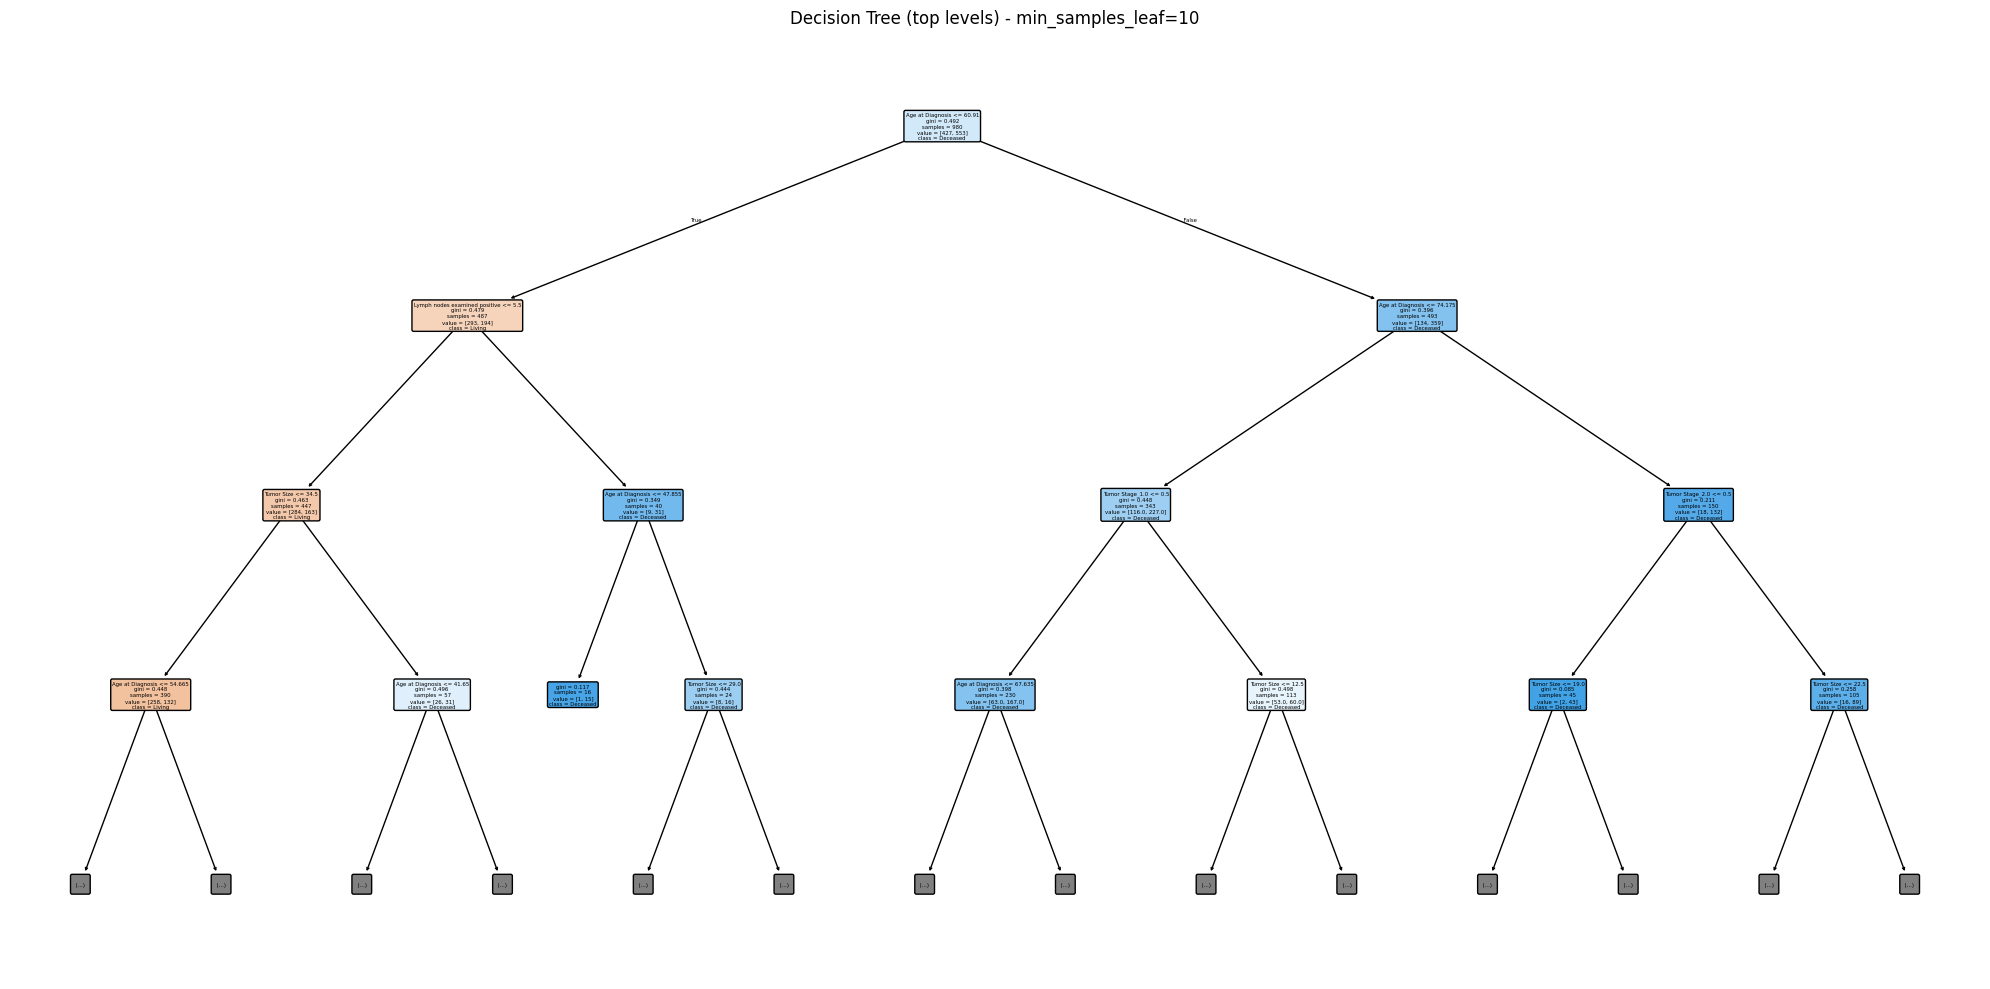

In [8]:
RSEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.30, random_state=RSEED, stratify=y_class)

clf = DecisionTreeClassifier(min_samples_leaf=10, random_state=RSEED)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
acc = accuracy_score(y_test, y_pred)
print("\nConfusion matrix (rows=true [Living=0, Deceased=1], cols=predicted [Living=0, Deceased=1]):")
print(cm)
print("\nOverall accuracy:", acc)

# compute TPR (sensitivity) and TNR (specificity) with Deceased=1 as positive:
tp = cm[1,1]
fn = cm[1,0]
tn = cm[0,0]
fp = cm[0,1]

tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
tnr = tn / (tn + fp) if (tn + fp) > 0 else np.nan
print(f"\nTPR (sensitivity, Deceased positive) = {tpr:.4f}")
print(f"TNR (specificity, Deceased positive) = {tnr:.4f}")

print("\nClassification report (precision / recall / f1):")
print(classification_report(y_test, y_pred, target_names=['Living(0)','Deceased(1)']))

# plot dendrogram-like tree
plt.figure(figsize=(20,10))
# show only top levels with max_depth param in plot_tree for readability
plot_tree(clf, feature_names=X.columns, class_names=['Living','Deceased'], filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree (top levels) - min_samples_leaf=10")
plt.tight_layout()
plt.show()

In [ ]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, y_reg, test_size=0.30, random_state=RSEED)

# search for best min_samples_leaf
leaf_values = list(range(1, 201, 5))
best_leaf = None
best_r2 = -np.inf
for leaf in leaf_values:
    reg = DecisionTreeRegressor(min_samples_leaf=leaf, random_state=RSEED)
    reg.fit(Xr_train, yr_train)
    ypred = reg.predict(Xr_test)
    r2 = r2_score(yr_test, ypred)
    if r2 > best_r2:
        best_r2 = r2
        best_leaf = leaf

# optional fine search around best_leaf
fine_low = max(1, best_leaf - 50)
fine_high = best_leaf + 50
best_leaf_fine = best_leaf
best_r2_fine = best_r2
for leaf in range(fine_low, fine_high + 1):
    reg = DecisionTreeRegressor(min_samples_leaf=leaf, random_state=RSEED)
    reg.fit(Xr_train, yr_train)
    ypred = reg.predict(Xr_test)
    r2 = r2_score(yr_test, ypred)
    if r2 > best_r2_fine:
        best_r2_fine = r2
        best_leaf_fine = leaf

print(f"\nBest min_samples_leaf (coarse) = {best_leaf}, R2 = {best_r2:.6f}")
print(f"Best min_samples_leaf (fine)   = {best_leaf_fine}, R2 = {best_r2_fine:.6f}")

# retrain final regressor with best leaf
reg_final = DecisionTreeRegressor(min_samples_leaf=best_leaf_fine, random_state=RSEED)
reg_final.fit(Xr_train, yr_train)
yreg_pred = reg_final.predict(Xr_test)
final_r2 = r2_score(yr_test, yreg_pred)
print(f"\nFinal test R^2 (min_samples_leaf={best_leaf_fine}): {final_r2:.6f}")

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(yr_test, yreg_pred, alpha=0.6)
mn = min(yr_test.min(), yreg_pred.min())
mx = max(yr_test.max(), yreg_pred.max())
plt.plot([mn, mx], [mn, mx], linestyle='--', linewidth=1)
plt.xlabel("True Overall Survival (Months) - test")
plt.ylabel("Predicted Overall Survival (Months) - test")
plt.title(f"True vs Predicted (Decision Tree Regressor, min_samples_leaf={best_leaf_fine})\nR^2 = {final_r2:.4f}")
plt.grid(True)
plt.tight_layout()
plt.show()

# R^2 near 0.1 indicates the regression tree explains little variance in survival
# months. For clinical use, we would want much higher predictive performance and
# careful external validation.

**Q3.** This is a case study about trees using bond rating data. This is a dataset about bond ratings for different companies, alongside a bunch of business statistics and other data. Companies often have multiple reviews at different dates. We want to predict the bond rating (AAA, AA, A, BBB, BB, B, ..., C, D). Do business fundamentals predict the company's rating?

1. Load the `./data/corporate_ratings.csv` dataset. How many observations and variables does it contain? Print out the first few rows of data.

2.  Plot a histogram of the `ratings` variable. It turns out that the gradations of AAA/AA/A and BBB/BB/B and so on make it hard to get good results with trees. Collapse all AAA/AA/A ratings into just A, and similarly for B and C.

3. Use all of the variables **except** Rating, Date, Name, Symbol, and Rating Agency Name. To include Sector, make a dummy/one-hot-encoded representation and include it in your features/covariates. Collect the relevant variables into a data matrix $X$.

4. Do a train/test split of the data and use a decision tree classifier to predict the bond rating. Including a min_samples_leaf constraint can raise the accuracy and speed up computation time. Print a confusion matrix and the accuracy of your model. How well do you predict the different bond ratings?

5. If you include the rating agency as a feature/covariate/predictor variable, do the results change? How do you interpret this?